# Kickstarter Predictions for Pledge Levels

The project pledge level is a value from 1 to 4, where 1 means funding of no more than 10% of the project goal, 2 means funding of more than 10% but no more than 100% of the project goal, 3 means funding of more than 100% but no more than 1000% of the project goal, and 4 means funding of more than 1000% of the project goal.

The performance of your classifier will be measured by the mean squared error for predictions. For example if classifier predicts 2 as the pledge level, but the actual pledge level is 4, then the squared error is (4-2)^2, or 4. The mean squared error is the squared error averaged across all of your predictions on the test data set.

## Import Packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import train_test_split
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import argparse
warnings.filterwarnings('ignore')

## Load Data

In [10]:
data=pd.read_csv('kickstarter-train-classifier.csv',
                 index_col=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294928 entries, 0 to 294927
Data columns (total 9 columns):
name             294924 non-null object
category         294928 non-null object
main_category    294928 non-null object
currency         294928 non-null object
deadline         294928 non-null object
launched         294928 non-null object
country          294928 non-null object
usd_goal_real    294928 non-null float64
pledge_level     294928 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 20.3+ MB


## Data Wrangling

In [11]:
#Creating new columns
data['deadline']=data['deadline'].apply(pd.to_datetime)
data['launched']=data['launched'].apply(pd.to_datetime)

In [12]:
data['Howlong']=data['deadline']-data['launched']
data['Howlong'].head()

0   29 days 07:25:25
1   29 days 13:20:17
2   20 days 06:23:43
3   29 days 04:18:52
4   27 days 23:00:27
Name: Howlong, dtype: timedelta64[ns]

In [13]:
data['Howlong']=data.Howlong.astype('str').str.split(' ').str[0]
data['Howlong']=data.Howlong.astype('int32')
data.head()

,name,category,main_category,currency,deadline,launched,country,usd_goal_real,pledge_level,Howlong
0,Zombie Awareness (Canceled),Fashion,Fashion,USD,2015-09-30,2015-08-31 16:34:35,US,1500.00,1,29
1,Cyberunity,Mobile Games,Games,USD,2017-05-13,2017-04-13 10:39:43,US,30000.00,1,29
2,Common Ground: Christians and the Message of B...,Documentary,Film & Video,USD,2015-11-13,2015-10-23 17:36:17,US,10000.00,2,20
3,Start-Up Platform,Web,Technology,GBP,2014-09-11,2014-08-12 19:41:08,GB,162.33,1,29
4,Squidfires Winter Collection,Fashion,Fashion,USD,2011-11-01,2011-10-04 00:59:33,US,2000.00,1,27


In [14]:
# Drop the NaN values
data_a=data.dropna()
data_a.loc[data_a['name'].str.contains("anceled"),'canceled']=1

In [15]:
dfs=data_a.drop(['name','deadline','launched'],axis=1)
value={'canceled': 0}
dfs.fillna(value=value,inplace=True)
dfs.head()

,category,main_category,currency,country,usd_goal_real,pledge_level,Howlong,canceled
0,Fashion,Fashion,USD,US,1500.00,1,29,1.0
1,Mobile Games,Games,USD,US,30000.00,1,29,0.0
2,Documentary,Film & Video,USD,US,10000.00,2,20,0.0
3,Web,Technology,GBP,GB,162.33,1,29,0.0
4,Fashion,Fashion,USD,US,2000.00,1,27,0.0


In [46]:
num_canceled=dfs[dfs.canceled==1]
print(len(num_canceled),' number of project canceled')

17809  number of project canceled


In [16]:
# rename the target column
df = dfs.rename(columns={'pledge_level': 'pledgelevel'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294924 entries, 0 to 294927
Data columns (total 8 columns):
category         294924 non-null object
main_category    294924 non-null object
currency         294924 non-null object
country          294924 non-null object
usd_goal_real    294924 non-null float64
pledgelevel      294924 non-null int64
Howlong          294924 non-null int32
canceled         294924 non-null float64
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 19.1+ MB


In [17]:
# Value caunts
df['pledgelevel'].value_counts()

1    140013
3     98983
2     52652
4      3276
Name: pledgelevel, dtype: int64

## Upsampling the imbalance data

In [18]:
from sklearn.utils import resample
y=df['pledgelevel']
X=df.drop('pledgelevel', axis=1)
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.4,random_state=42)

In [19]:
X_new = pd.concat([X_train, y_train], axis=1)
low = X_new[X_new.pledgelevel==4]
middlelow= X_new[X_new.pledgelevel==2]
middlehigh= X_new[X_new.pledgelevel==3]
high = X_new[X_new.pledgelevel==1]

In [20]:
low_upsampled = resample(low,
                          replace=True, # sample with replacement
                          n_samples=len(high), # match number in majority class
                          random_state=27) # reproducible results
middlelow_upsampled=resample(middlelow,
                          replace=True,
                          n_samples=len(high),
                          random_state=27)
middlehigh_upsampled=resample(middlehigh,
                          replace=True,
                          n_samples=len(high),
                          random_state=27)
# combine majority and upsampled minority
upsampled = pd.concat([high, low_upsampled,middlelow_upsampled,middlehigh_upsampled])

# check new class counts
upsampled.pledgelevel.value_counts()

4    83931
3    83931
2    83931
1    83931
Name: pledgelevel, dtype: int64

In [21]:
upsampled.head()

,category,main_category,currency,country,usd_goal_real,Howlong,canceled,pledgelevel
152975,Fiction,Publishing,USD,US,7500.0,44,0.0,1
175797,Wearables,Technology,USD,US,17000.0,29,0.0,1
226883,Restaurants,Food,USD,US,50000.0,29,0.0,1
16691,Rock,Music,USD,US,10000.0,34,0.0,1
155966,Technology,Technology,USD,US,30000.0,29,0.0,1


In [22]:
y=upsampled.pledgelevel
X=upsampled.drop('pledgelevel', axis=1)
features = X.as_matrix()
target=y.as_matrix()

## Create custom transformers

*PositionalSelector:* Given a list of indices C and a matrix M, this returns a matrix with a subset of M's columns, indicated by C.

*StripString:* Given a matrix of strings, this strips whitespaces from each string.

*SimpleOneHotEncoder:* A simple one-hot encoder which can be applied to a matrix of strings.

In [23]:
class PositionalSelector(BaseEstimator, TransformerMixin):
    def __init__(self, positions):
        self.positions = positions

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:, self.positions]


class StripString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        strip = np.vectorize(str.strip)
        return strip(np.array(X))


class SimpleOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.values = []
        for c in range(X.shape[1]):
            Y = X[:, c]
            values = {v: i for i, v in enumerate(np.unique(Y))}
            self.values.append(values)
        return self

    def transform(self, X):
        X = np.array(X)
        matrices = []
        for c in range(X.shape[1]):
            Y = X[:, c]
            matrix = np.zeros(shape=(len(Y), len(self.values[c])), dtype=np.int8)
            for i, x in enumerate(Y):
                if x in self.values[c]:
                    matrix[i][self.values[c][x]] = 1
            matrices.append(matrix)
        res = np.concatenate(matrices, axis=1)
        return res

## Random Forest Clssifier

In [24]:
def create_pipeline():
    numerical_indices = [4,5,6] 
    categorical_indices = [0,1,2,3] 
    p1 = make_pipeline(PositionalSelector(categorical_indices), StripString(), SimpleOneHotEncoder())
    p2 = make_pipeline(PositionalSelector(numerical_indices), StandardScaler())
    feats = FeatureUnion([
        ('numericals', p1),
        ('categoricals', p2)
    ])

    pipeline = Pipeline([
        ('pre', feats),
        ('estimator', RandomForestClassifier(max_depth=15,n_estimators=100))
    ])
    return pipeline

In [25]:
X=features
y=target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [26]:
pipeline = create_pipeline()
sample=pipeline.fit(X_train,y_train)

In [27]:
prediction=sample.predict(X_test)
accuracy_score(y_test, prediction)

0.5521632288331223

In [33]:
def compute_mse(prediction, y_test):
    """ Compute Root Mean Squared Error. """
    
    return np.mean(np.power(prediction - y_test, 2))

In [34]:
print('MSE for estimate1:',compute_mse(prediction, y_test))

MSE for estimate1: 1.200178717700499


## Gradient Boosting Classifier

In [35]:
def create_pipeline():
    numerical_indices = [4,5,6] 
    categorical_indices = [0,1,2,3] 
    p1 = make_pipeline(PositionalSelector(categorical_indices), StripString(), SimpleOneHotEncoder())
    p2 = make_pipeline(PositionalSelector(numerical_indices), StandardScaler())
    feats = FeatureUnion([
        ('numericals', p1),
        ('categoricals', p2)
    ])

    pipeline = Pipeline([
        ('pre', feats),
        ('estimator', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                                 max_depth=1, random_state=0))
    ])
    return pipeline

In [36]:
pipeline_1 = create_pipeline()
sample_1=pipeline_1.fit(X_train,y_train)

In [37]:
prediction_1=sample_1.predict(X_test)
accuracy_score(y_test, prediction_1)

0.5208876312458113

In [38]:
print('MSE for estimate1:',compute_mse(prediction_1, y_test))

MSE for estimate1: 1.2646660212971927


## Extra Trees Classifier

In [39]:
def create_pipeline():
    numerical_indices = [4,5,6] 
    categorical_indices = [0,1,2,3] 
    p1 = make_pipeline(PositionalSelector(categorical_indices), StripString(), SimpleOneHotEncoder())
    p2 = make_pipeline(PositionalSelector(numerical_indices), StandardScaler())
    feats = FeatureUnion([
        ('numericals', p1),
        ('categoricals', p2)
    ])

    pipeline = Pipeline([
        ('pre', feats),
        ('estimator', ExtraTreesClassifier(n_estimators=200, max_depth=None,
                                           min_samples_split=6, random_state=0))
    ])
    return pipeline

In [40]:
pipeline_2 = create_pipeline()
sample_2=pipeline_2.fit(X_train,y_train)

In [41]:
prediction_2=sample_2.predict(X_test)
accuracy_score(y_test, prediction_2)

0.7253257874748679

In [42]:
print('MSE for estimate1:',compute_mse(prediction_2, y_test))

MSE for estimate1: 0.6465112815548439


#### Cohen Kappa Score

![picture](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2014/12/cohens-kappa-statistic.png)

In [43]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
print('cohen kappa score:',cohen_kappa_score(y_test, prediction_2))
cm=confusion_matrix(y_test, prediction_2)
print(cm)

cohen kappa score: 0.6337851968210766
[[ 9710  3252  3367   524]
 [ 2394 11422  2151   779]
 [ 2522  2466 10997   779]
 [   60    97    52 16573]]


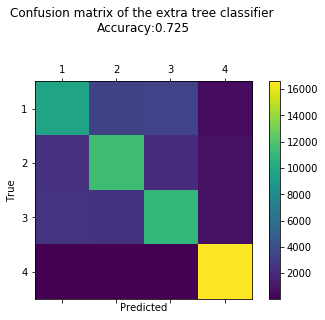

In [27]:
import seaborn as sn
labels=[1, 2, 3, 4]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the extra tree classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, prediction_2)),y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Predicting the new data set

### Load the new test data

In [28]:
tst=pd.read_csv('kickstarter-test-classifier-no-labels.csv')
tst.head()

,name,category,main_category,currency,deadline,launched,country,usd_goal_real
0,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,US,45000.00
1,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2013-09-09 18:19:37,CA,2406.39
2,The Cottage Market,Crafts,Crafts,USD,2014-10-02,2014-09-02 17:11:50,US,5000.00
3,The Beard,Comic Books,Comics,USD,2014-11-08,2014-10-09 22:27:52,US,1500.00
4,Rebel Army Origins: The Heroic Story Of Major ...,Comics,Comics,GBP,2016-01-28,2015-12-29 16:59:29,GB,142.91


## Data Wrangling

In [29]:
tst['deadline']=tst['deadline'].apply(pd.to_datetime)
tst['launched']=tst['launched'].apply(pd.to_datetime)

In [30]:
tst['Howlong']=tst['deadline']-tst['launched']
tst['Howlong'].head()

0   44 days 23:39:10
1   29 days 05:40:23
2   29 days 06:48:10
3   29 days 01:32:08
4   29 days 07:00:31
Name: Howlong, dtype: timedelta64[ns]

In [31]:
tst['Howlong']=tst.Howlong.astype('str').str.split(' ').str[0]
tst['Howlong']=tst.Howlong.astype('int32')
tst.head()

,name,category,main_category,currency,deadline,launched,country,usd_goal_real,Howlong
0,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,US,45000.00,44
1,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09,2013-09-09 18:19:37,CA,2406.39,29
2,The Cottage Market,Crafts,Crafts,USD,2014-10-02,2014-09-02 17:11:50,US,5000.00,29
3,The Beard,Comic Books,Comics,USD,2014-11-08,2014-10-09 22:27:52,US,1500.00,29
4,Rebel Army Origins: The Heroic Story Of Major ...,Comics,Comics,GBP,2016-01-28,2015-12-29 16:59:29,GB,142.91,29


In [32]:
data_b=tst.dropna()
data_b.loc[data_b['name'].str.contains("anceled"),'canceled']=1

In [33]:
dfz=data_b.drop(['name','deadline','launched'],axis=1)
value={'canceled': 0}
dfz.fillna(value=value,inplace=True)
dfz.head()

,category,main_category,currency,country,usd_goal_real,Howlong,canceled
0,Narrative Film,Film & Video,USD,US,45000.00,44,0.0
1,Nonfiction,Publishing,CAD,CA,2406.39,29,0.0
2,Crafts,Crafts,USD,US,5000.00,29,0.0
3,Comic Books,Comics,USD,US,1500.00,29,0.0
4,Comics,Comics,GBP,GB,142.91,29,0.0


In [34]:
X_test=dfz.as_matrix()

## Predictions

In [35]:
prediction_new=sample_2.predict(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
new_pred=pd.DataFrame(prediction_new)
new_pred.to_csv('result.csv',index=False,header=False)
new=pd.read_csv('result.csv')
new.shape

(73732, 1)